<a href="https://colab.research.google.com/github/kavyajeetbora/modern_geospatial_stack/blob/master/notebooks/02_download_metro_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO:

1. Evaluate the downloaded data from https://themetrorailguy.com/
2. Once evaluated, export it to parquet format

## Install Dependencies and Import Modules

In [11]:
!pip install -q osmnx
!pip install -q pydeck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 35.9 MB/s eta 0:00:00


In [17]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
from tqdm import tqdm
import pydeck as pdk
import shapely

## Download OSM Data

In [3]:
## Note: the coordinates are in West, South, East, North format

bboxs = {
    'Mumbai': (72.7712628039,18.8895552464,73.0912396106,19.322318006),
    'Hyderabad': (78.2288393192,17.1952635128,78.692325037,17.6244114807),
    'Bangalore': (77.4480254838,12.815481916,77.7549560258,13.1026335949),
    'Chennai': (80.0337033915,12.8678089117,80.335827415,13.2370438819),
    'Kolkata': (88.2431406976,22.4883995072,88.4944529534,22.7071046611),
    'Ahmedabad': (72.4617185823,22.9179551449,72.699297928,23.1470216925),
    'Delhi_NCR': (76.881197,28.31444,77.604922,28.893765)
}

columns = ['element_type', 'osmid', 'geometry', 'railway', 'internet_access',
       'name', 'name:hi', 'network', 'operator', 'public_transport',
       'ref', 'train','city']

In [130]:
%%time
city = 'Mumbai'
W,S,E,N = bboxs[city]
public_transport = ox.features.features_from_bbox(bbox=(N,S,E,W), tags={'station':'subway', 'building': 'train_station'}).reset_index()
print("Number of features found:", public_transport.shape[0])
public_transport[['name', 'public_transport']].head()

Number of features found: 148
CPU times: user 641 ms, sys: 15.3 ms, total: 657 ms
Wall time: 2.95 s


,name,public_transport
0,Dahanukarwadi,station
1,Kandivali West,station
2,Borivali West,station
3,Mandapeshwar,station
4,Kandarpada,station


In [132]:
public_transport['element_type'].value_counts()

element_type
way     114
node     34
Name: count, dtype: int64

In [133]:
public_transport = public_transport.set_crs('EPSG:4326')
relation = public_transport[public_transport['element_type']!='node'].copy()
nodes = public_transport[public_transport['element_type']=='node'].copy()
nodes['geometry'] = nodes['geometry'].to_crs('EPSG:4326').buffer(distance=1e-3, cap_style='square').to_crs('EPSG:4326')

gdf_final = pd.concat([relation, nodes])
gdf_final = relation
gdf_final = gdf_final[['name','public_transport','geometry']].fillna("NA")
gdf_final.sample(10)

<ipython-input-133-180314778762>:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nodes['geometry'] = nodes['geometry'].to_crs('EPSG:4326').buffer(distance=1e-3, cap_style='square').to_crs('EPSG:4326')


,name,public_transport,geometry
68,NA,NA,"POLYGON ((72.89359 19.04354, 72.89336 19.04353..."
51,NA,NA,"POLYGON ((72.84754 19.11848, 72.84720 19.11853..."
107,Sector-34,station,"POLYGON ((73.08112 19.07367, 73.08117 19.07388..."
87,NA,NA,"POLYGON ((72.92859 19.11185, 72.92840 19.11186..."
135,NA,NA,"POLYGON ((72.85535 19.12776, 72.85532 19.12945..."
42,NA,NA,"POLYGON ((72.82417 18.94476, 72.82431 18.94485..."
46,NA,NA,"POLYGON ((72.89704 19.07957, 72.89711 19.07948..."
126,NA,NA,"POLYGON ((72.89762 19.07860, 72.89757 19.07866..."
125,Parel,NA,"POLYGON ((72.83725 19.00825, 72.83735 19.00819..."
100,NA,NA,"POLYGON ((72.85613 19.28166, 72.85591 19.28165..."


In [134]:
def create_map(W,S,E,N, Layer=None):
    bbox_geom = shapely.geometry.box(W,S,E,N)
    boundary_json = eval(gpd.GeoSeries(bbox_geom).to_json())

    boundary_layer = pdk.Layer(
        "GeoJsonLayer",
        boundary_json,
        opacity=1,
        stroked=True,
        filled=False,
        get_line_color=[100, 0, 0]
    )
    if Layer is not None:
        layer = pdk.Layer(
            "GeoJsonLayer",
            Layer,
            opacity=1,
            stroked=True,
            filled=True,
            get_fill_color=[100, 200, 0],
            get_line_color=[0,100,0],
            pickable=True
        )
        layers = [boundary_layer, layer]
    else:
        layers = [boundary_layer]


    C = bbox_geom.centroid
    view_state = pdk.ViewState(latitude=C.y, longitude=C.x, zoom=11, bearing=0, pitch=45)
    # Render

    r = pdk.Deck(layers=layers, initial_view_state=view_state, tooltip = True)
    return r

In [135]:
layer = eval(gdf_final.to_json())
create_map(W,S,E,N, layer)

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 19.1059366262,
    "longitude": 72.93125120724999,
    "pitch": 45,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "GeoJsonLayer",
      "data": {
        "bbox": [
          72.7712628039,
          18.8895552464,
          73.0912396106,
          19.322318006
        ],
        "features": [
          {
            "bbox": [
              72.7712628039,
              18.8895552464,
              73.0912396106,
              19.322318006
            ],
            "geometry": {
              "coordinates": [
                [
                  [
                    73.0912396106,
                    18.8895552464
                  ],
                  [
                    73.0912396106,
                    19.322318006
                  ],
                  [
                    72.7712628039,
                    19.322318006
                  ],
                  [
                    72.7712628039,
                    18.8895552464
                  ],
                  [
                    73.0912396106,
                    18.8895552464
                  ]
                ]
              ],
              "type": "Polygon"
            },
            "id": "0",
            "properties": {},
            "type": "Feature"
          }
        ],
        "type": "FeatureCollection"
      },
      "filled": false,
      "getLineColor": [
        100,
        0,
        0
      ],
      "id": "65554642-4a06-4793-90ed-d81916b671ff",
      "opacity": 1,
      "stroked": true
    },
    {
      "@@type": "GeoJsonLayer",
      "data": {
        "features": [
          {
            "geometry": {
              "coordinates": [
                [
                  [
                    72.8348034,
                    18.9421486
                  ],
                  [
                    72.8347866,
                    18.942298
                  ],
                  [
                    72.8348686,
                    18.9423062
                  ],
                  [
                    72.834878,
                    18.9423071
                  ],
                  [
                    72.8348574,
                    18.9425125
                  ],
                  [
                    72.8348976,
                    18.942516
                  ],
                  [
                    72.8349401,
                    18.9425195
                  ],
                  [
                    72.8351166,
                    18.9425328
                  ],
                  [
                    72.8351734,
                    18.942537
                  ],
                  [
                    72.8352041,
                    18.9425393
                  ],
                  [
                    72.8352344,
                    18.9425417
                  ],
                  [
                    72.8352773,
                    18.942545
                  ],
                  [
                    72.8353091,
                    18.9425475
                  ],
                  [
                    72.8353461,
                    18.9425504
                  ],
                  [
                    72.8353788,
                    18.9425531
                  ],
                  [
                    72.83541,
                    18.9425558
                  ],
                  [
                    72.83547,
                    18.9425613
                  ],
                  [
                    72.8355178,
                    18.9425657
                  ],
                  [
                    72.835721,
                    18.9405871
                  ],
                  [
                    72.8357305,
                    18.9404975
                  ],
                  [
                    72.8357434,
                    18.9403797
                  ],
                  [
                    72.835016,
                    18.9403081
       

,name,public_transport,geometry
0,Dahanukarwadi,station,POINT (72.83477 19.20624)
1,Kandivali West,station,POINT (72.83729 19.21401)
2,Borivali West,station,POINT (72.84086 19.23139)
3,Mandapeshwar,station,POINT (72.84560 19.24961)
4,Kandarpada,station,POINT (72.85050 19.25663)
5,Anand Nagar (Dahisar),station,POINT (72.86635 19.25721)
6,Shimpoli,station,POINT (72.84091 19.22283)
7,Eksar,station,POINT (72.84345 19.24038)
8,Andheri,station,POINT (72.84879 19.12046)
9,Dahisar (East) [Line 7],station,POINT (72.86667 19.25070)


<Axes: >

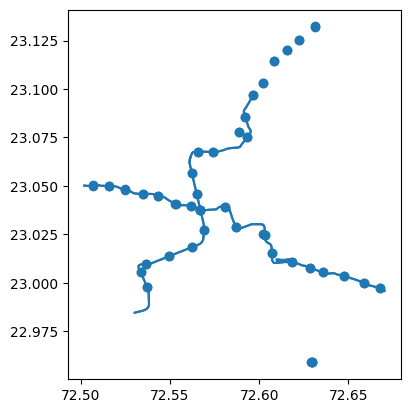

In [ ]:
ax= public_transport[public_transport['railway']=='subway'].plot()
public_transport[public_transport['railway']=='stop'].plot(ax=ax)

<Axes: >

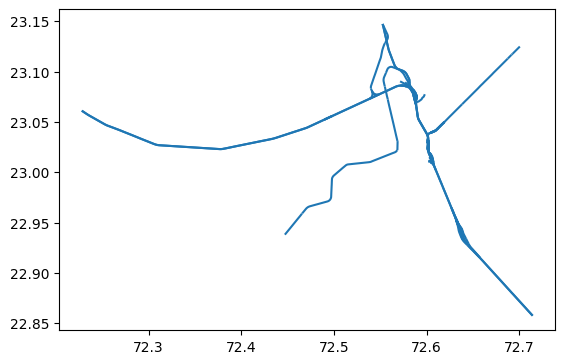

In [ ]:
public_transport[public_transport['railway']=='rail'].plot()

In [ ]:
%%time
# city = 'Dehli_NCR'
metro_stops = []
metro_lines = []

for city, bbox in tqdm(bboxs.items(), unit=' cities'):

    ## Download OSM data
    W,S,E,N = bboxs[city]
    public_transport = ox.features.features_from_bbox(bbox=(N,S,E,W), tags={'railway':True}).reset_index()
    public_transport['city'] = city
    # print("Length of the dataframe" , public_transport.shape[0])

    ## Extract Metro Stops
    stops = public_transport.loc[(public_transport['element_type']=='node') & (public_transport['railway']=='station')].copy()
    stops['city'] = city
    # print(f"Number of stations: {stops.shape[0]} in {city}")

    ## Extract Metro Lines
    lines = public_transport.loc[
        (public_transport['element_type']=='way') &
         (public_transport['railway'].notna())
    ].copy()

    lines['geometry'] = lines['geometry'].clip_by_rect(W,S,E,N)
    # print(f"Number of lines: {lines.shape[0]} in {city}")

    metro_lines.append(lines)
    metro_stops.append(stops)

metro_line_df = pd.concat(metro_lines)[columns]
metro_station_df = pd.concat(metro_stops)[columns]

print("Total number of metro lines: ", metro_line_df.shape[0])
print("Total number of metro stations: ", metro_station_df.shape[0])

100%|██████████| 7/7 [00:07<00:00,  1.10s/ cities]


Total number of metro lines:  11638
Total number of metro stations:  846
CPU times: user 8.67 s, sys: 94.5 ms, total: 8.77 s
Wall time: 9.16 s


## Evaluate the data

Evaluate the data by visualizing and inspecting the dataframes for each city

In [ ]:
metro_line_df[columns].sample(5)

,element_type,osmid,geometry,railway,internet_access,name,name:hi,network,operator,public_transport,ref,train,city
548,way,847089580,"LINESTRING (72.60979 23.01094, 72.61122 23.01093)",subway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ahmedabad
1044,way,356964961,"LINESTRING (78.51752 17.49836, 78.51770 17.497...",rail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hyderabad
6185,way,439020815,"LINESTRING (77.30284 28.54200, 77.30343 28.542...",subway,NaN,Delhi Metro Magenta Line,NaN,Delhi Metro,Delhi Metro Rail Corporation Limited,NaN,NaN,NaN,Delhi_NCR
4489,way,807900861,"LINESTRING (73.01562 19.20579, 73.01534 19.205...",rail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mumbai
1493,way,141182198,"LINESTRING (77.65239 12.99067, 77.65305 12.990...",subway,NaN,Namma Metro - Reach 1,NaN,Namma Metro,Bangalore Metro Rail Corporation Limited,NaN,NaN,NaN,Bangalore


## Visualize the Downloaded data

Visualize all the metro lines for a city

Number of lines: 39


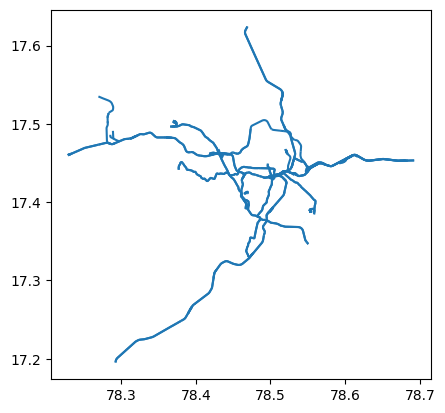

In [ ]:
city = "Hyderabad"
city_df = metro_line_df[metro_line_df['city']==city]
metro_lines = city_df.loc[(public_transport['railway']=='subway')]
print(f"Number of lines: {metro_lines.shape[0]}")
city_df.plot();

Number of stations: 18


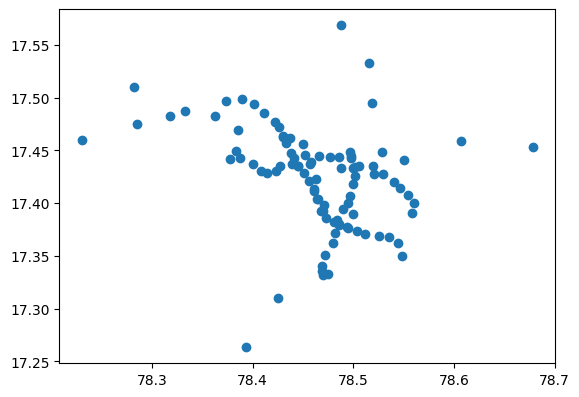

In [ ]:
city_stn_df = metro_station_df[metro_station_df['city']==city]
metro_stns = city_stn_df.loc[(public_transport['railway']=='subway')]
print(f"Number of stations: {metro_stns.shape[0]}")
city_stn_df.plot();

## Export to Parquet files

Once the evaluation of the data is done, export it to parquet format file

In [ ]:
metro_station_df.to_parquet('stations.parquet')
metro_line_df[columns].to_parquet('lines.parquet')